
Nesta lição, iremos implementar alguns conceitos de séries temporais.

This notebook is based on Sequence and time series prediction, Andrew NG, course


In [ ]:
#pd.read_csv(filepath_or_buffer, sep=',', delimiter=None, header='infer', names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, skipfooter=0, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, iterator=False, chunksize=None, compression='infer', thousands=None, decimal=b'.', lineterminator=None, quotechar='"', quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, dialect=None, tupleize_cols=None, error_bad_lines=True, warn_bad_lines=True, delim_whitespace=False, low_memory=True, memory_map=False, float_precision=None)
#Read a comma-separated values (csv) file into DataFrame.


# Setup

In [ ]:
#!pip install -U tf-nightly-2.0-preview
!pip install tensorflow==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1)
ERROR: No matching distribution found for tensorflow==2.0.1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
print(tf.__version__)

from tensorflow import keras

2.12.0


In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Trend and Seasonality

In [ ]:
def trend(time, slope=0):
    return slope * time

Let's create a time series that just trends upward:

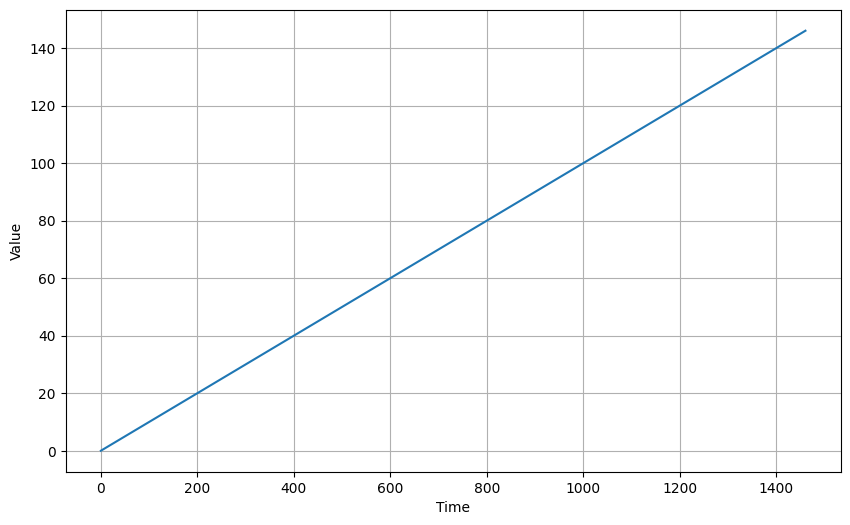

In [ ]:
time = np.arange(4 * 365 + 1)
baseline = 10
series = trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now let's generate a time series with a seasonal pattern:

In [ ]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

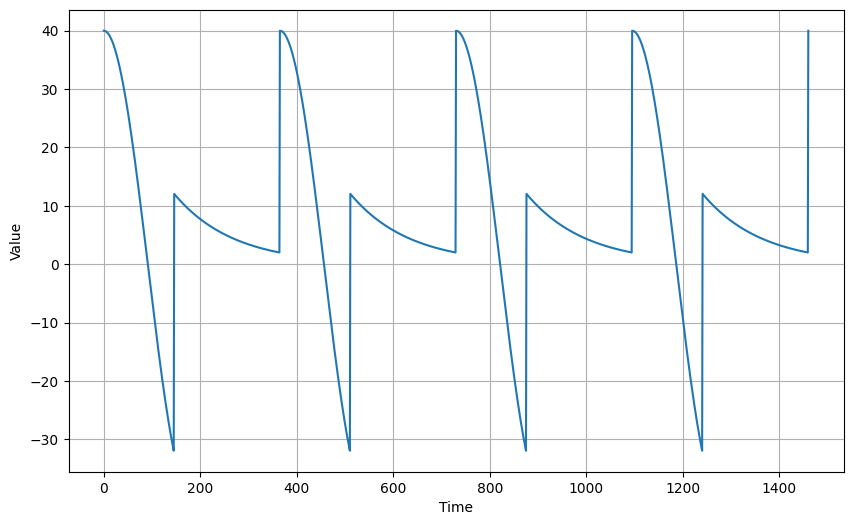

In [ ]:
baseline = 10
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now let's create a time series with both trend and seasonality:

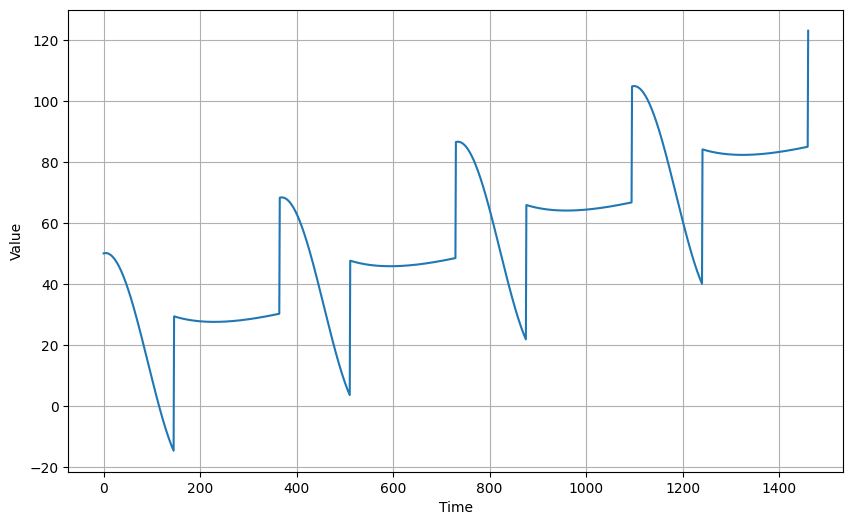

In [ ]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# Noise

In practice few real-life time series have such a smooth signal. They usually have some noise, and the signal-to-noise ratio can sometimes be very low. Let's generate some white noise:

In [ ]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

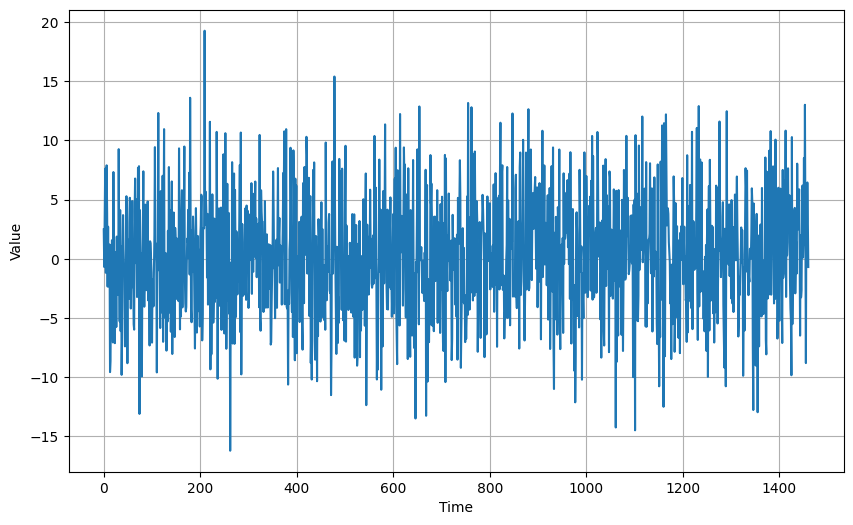

In [ ]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

Now let's add this white noise to the time series:

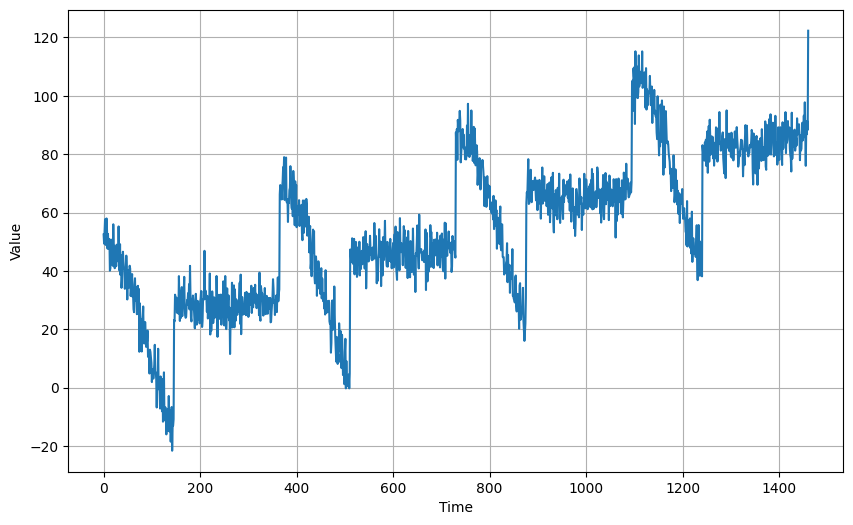

In [ ]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

All right, this looks realistic enough for now. Let's try to forecast it. We will split it into two periods: the training period and the validation period (in many cases, you would also want to have a test period). The split will be at time step 1000.

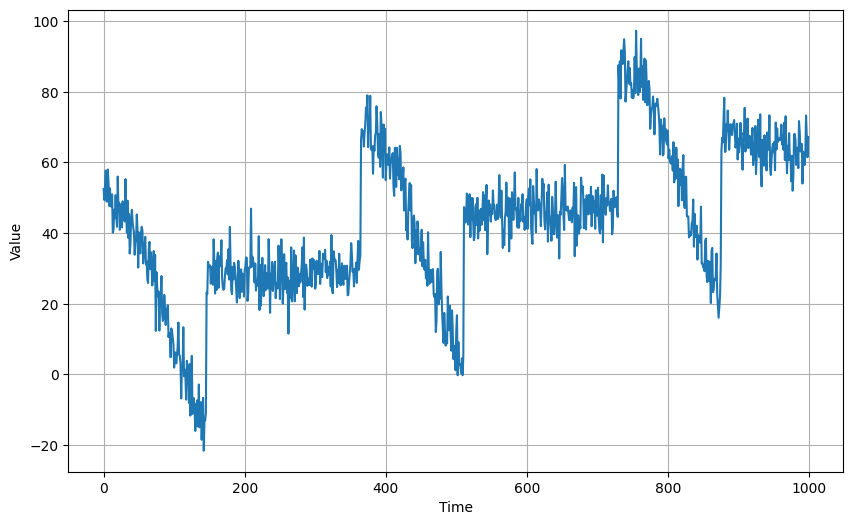

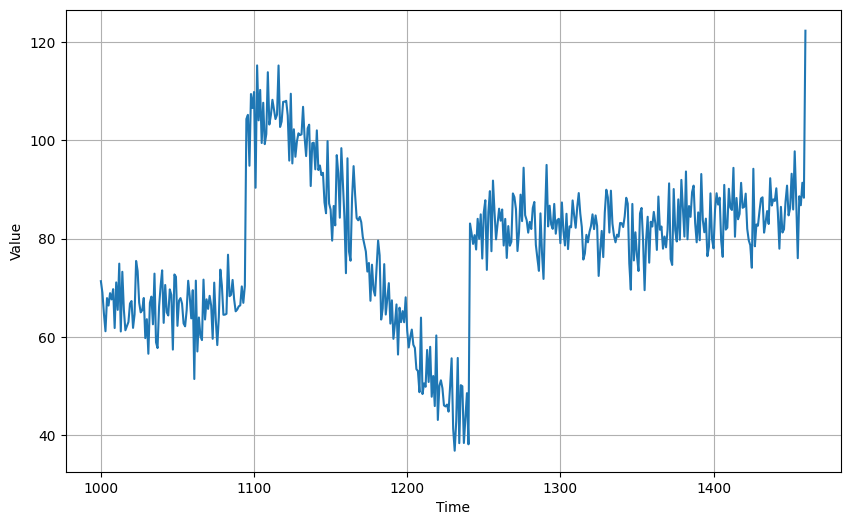

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

# Naive Forecast

In [ ]:
naive_forecast = series[split_time - 1:-1]

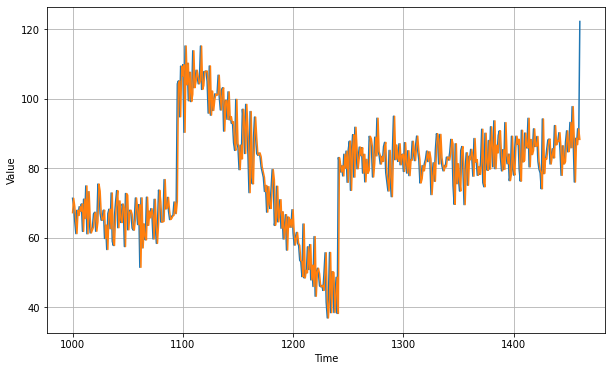

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

Let's zoom in on the start of the validation period:

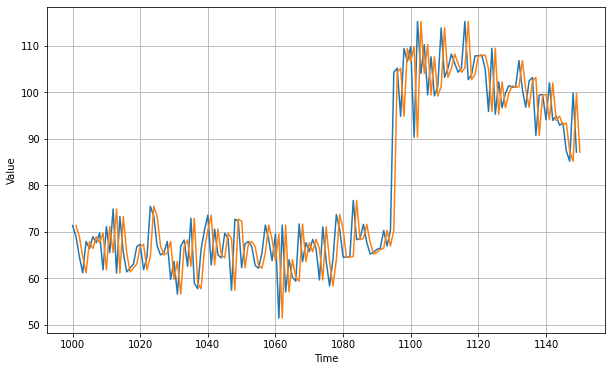

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period:

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.82753366856369
5.9379085153216735


That's our baseline, now let's try a moving average:

In [ ]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

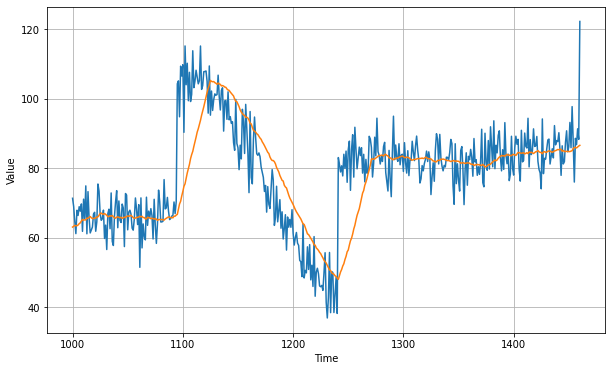

In [ ]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)


In [ ]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.6745665143116
7.142418570620878


That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time *t* – 365 from the value at time *t*.

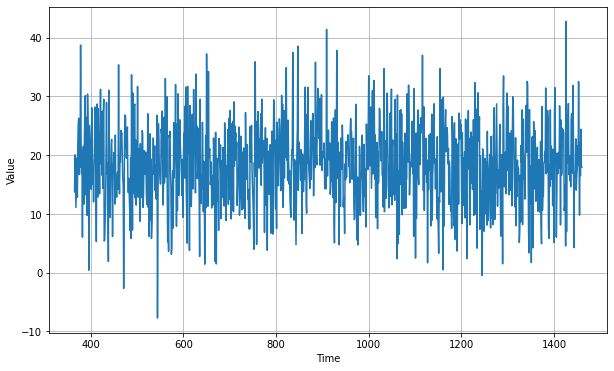

In [ ]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

Great, the trend and seasonality seem to be gone, so now we can use the moving average:

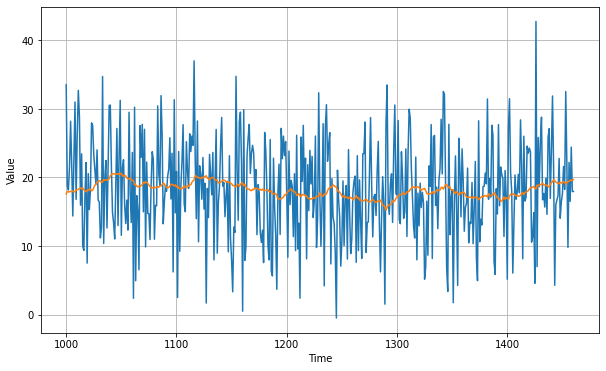

In [ ]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

Now let's bring back the trend and seasonality by adding the past values from t – 365:

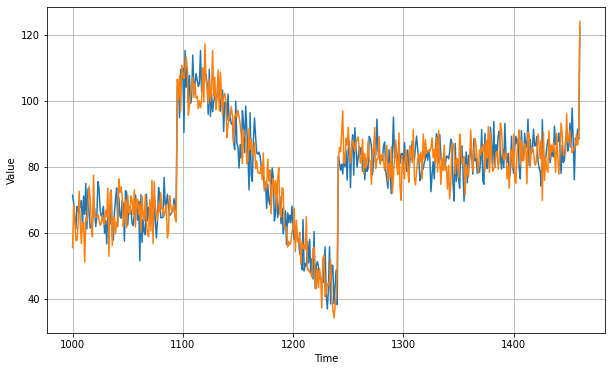

In [ ]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [ ]:

print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

52.973659999691854
5.839310562995894


Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

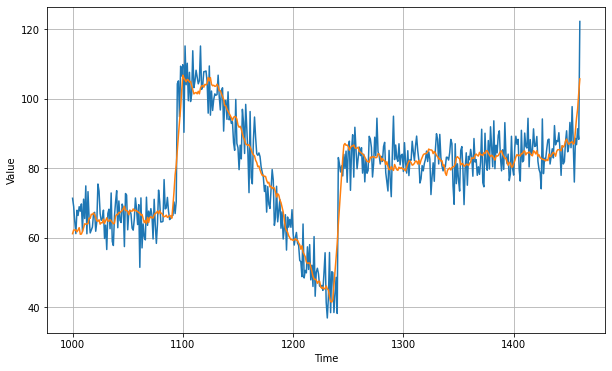

In [ ]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

33.45226092870011
4.569441847863209


# Lesson 2
A real dataset

Now, lets have a more real example.  In this case, we used the following dataset:

https://archive.ics.uci.edu/ml/datasets/air+quality
Some important notes about the dataset:


*   Missing data is marked as -200
*   There are several missing data
*   The separator char is ';'




In [ ]:
#Load files in the google drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

#You need to change your file location
#index_col="Date"
df = pd.read_csv("/content/gdrive/MyDrive/UFES - público/AirQualityUCI.csv",  sep=';', decimal=',',parse_dates=["Date"])
df.head()


<ipython-input-7-857cfa956ebb>:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv("/content/gdrive/MyDrive/UFES - público/AirQualityUCI.csv",  sep=';', decimal=',',parse_dates=["Date"])


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,2004-10-03,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,2004-10-03,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,2004-10-03,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,2004-10-03,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,2004-10-03,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [ ]:
print(df['T'])

0       13.6
1       13.3
2       11.9
3       11.0
4       11.2
        ... 
9466     NaN
9467     NaN
9468     NaN
9469     NaN
9470     NaN
Name: T, Length: 9471, dtype: float64


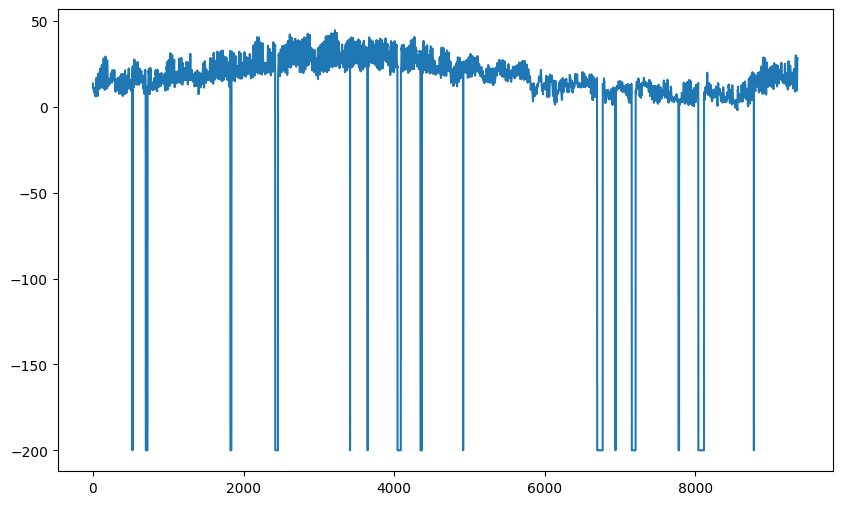

In [ ]:
plt.figure(figsize=(10, 6))
#plt.plot(time[start:end], series[start:end], format, label=label)
plt.plot(df['T'])
plt.show()

As we can see, there are several missing values.
**Exercise** Re-run naive algorithm with this dataframe


In [ ]:
#reloading the dataframe setting the missing values.
df = pd.read_csv("/content/gdrive/MyDrive/UFES - público/AirQualityUCI.csv",  na_values=['-200'], sep=';', decimal=',',parse_dates=["Date"])
df.head()

<ipython-input-12-e8da4ea6db2a>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv("/content/gdrive/MyDrive/UFES - público/AirQualityUCI.csv",  na_values=['-200'], sep=';', decimal=',',parse_dates=["Date"])


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,2004-10-03,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,2004-10-03,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,2004-10-03,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,2004-10-03,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,2004-10-03,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


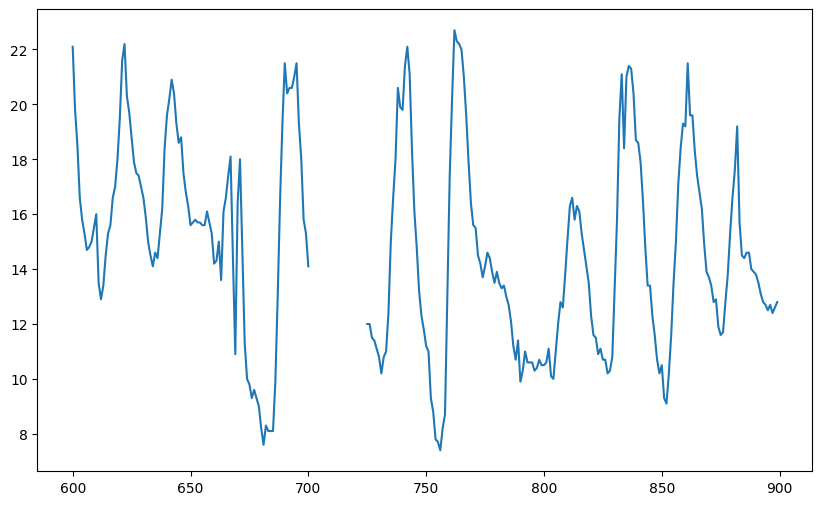

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['T'][600:900]) #zooming
plt.show()

The missing values where removed from the visualization but they are still there.

**Exercise** Re-run naive algorithm with this dataframe


### Handling  missing data

* Dropping null data
   * dropna()

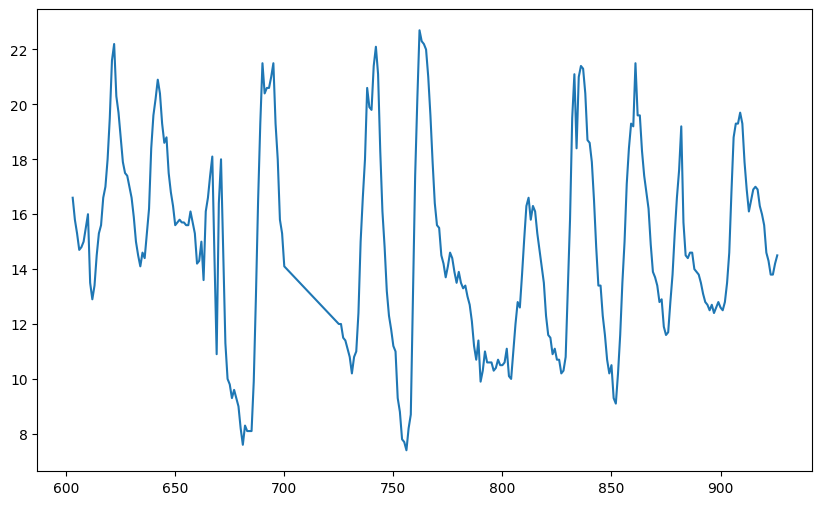

In [ ]:
df2  = df['T']
df2 = df2.dropna(axis='rows')

plt.figure(figsize=(10, 6))
plt.plot(df2[600:900]) #zooming
plt.show()

# Conclusão aqui: na imagem do plot parece que foi feita uma interpolação, mas, na verdade os valores não existem.

* Filling forward an backward
    * fillna()


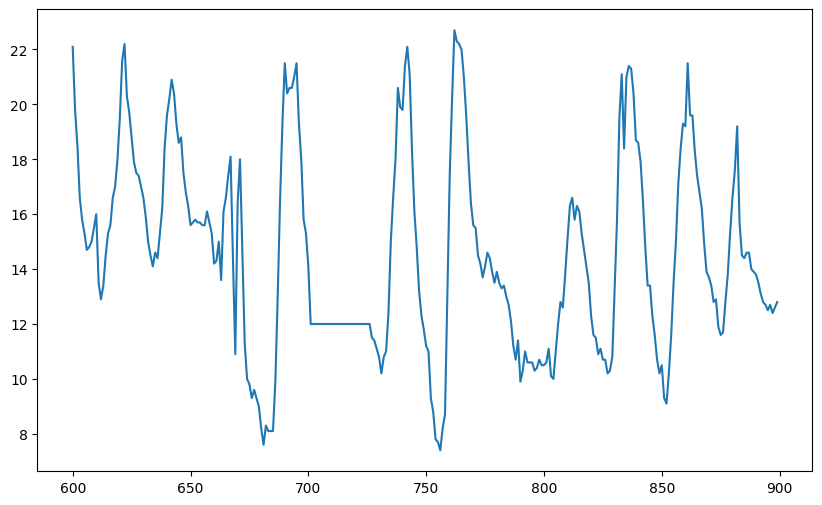

In [ ]:
#Evaluating several methods of filling NaN values.
df3  = df['T']
#df3 = df3.fillna(0)
#df3 = df3.fillna(method = 'ffill')
df3 = df3.fillna(method = 'bfill')
plt.figure(figsize=(10, 6))
plt.plot(df3[600:900]) #zooming
plt.show()

* Interpolating
    * interpolate

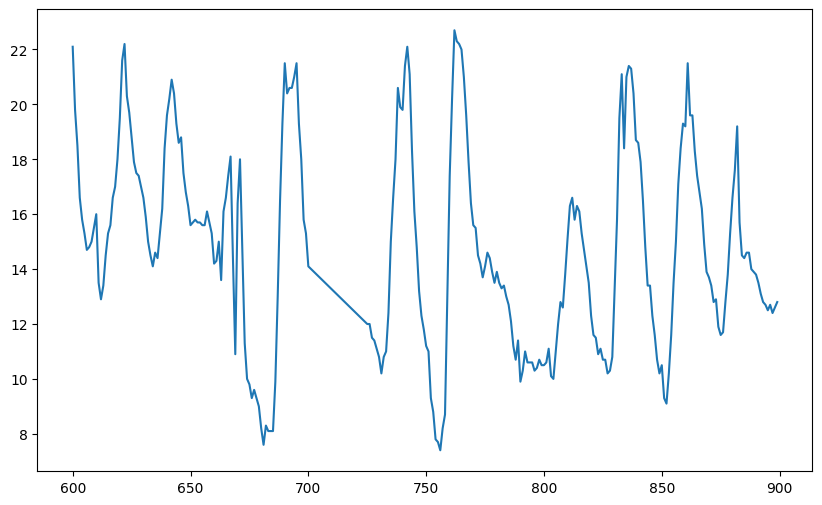

In [ ]:
#Interpolation may give appropriate values
df4  = df['T']
df4 = df4.interpolate(method='values')
#df4 = df4.interpolate(method='quadratic')
plt.figure(figsize=(10, 6))
plt.plot(df4[600:900]) #zooming
plt.show()

The method of replacing missing values makes difference on the evaluation.
**Exercise** Re-run naive algorithm with each of fillna method


In [ ]:
# EXERCÍCIO: rodar o naive e ver "mean square" e  "mean absolute error" para cada método de lidar com nulos.